In [2]:
# implementation of simple multiply layer
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy


# implementation of simple sum layer
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out

    def backward(self, dout):
        dx = dout
        dy = dout
        return dx, dy


    

In [3]:
# implementation of RELU layer
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        # create a bool mask to record the value < 0
        # mask can also be used in the BP process
        self.mask = (x <= 0) 
        out  = x.copy()
        out[self.mask] = 0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [4]:
import numpy as np
x = np.array([[1.0, -.5],
              [-.4, 9.0]])
print(x)
mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-0.4  9. ]]
[[False  True]
 [ True False]]


In [5]:
# implementation of Sigmoid layer
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

*sigmoid function* <br>
$y = \frac{1}{1 + \exp{-x}}$ <br>

based on the back propagation process, we can calculate the differential of sigmoid<br><br>
$\frac{\partial L}{\partial y}$ <br>
--> $-\frac{\partial L}{\partial y}y^2$ <br>
--> $-\frac{\partial L}{\partial y}y^2$ <br>
--> $\frac{\partial L}{\partial y}y^2$

simplify: <br>
$\frac{\partial L}{\partial y}y^2$ <br>
$= \frac{\partial L}{\partial y}\frac{1}{(1 + \exp{-x})^2}\exp(-x)$ <br>
$= \frac{\partial L}{\partial y}\frac{1}{1 + \exp{-x}}\frac{\exp(-x)}{1 + \exp{-x}}$ <br>
$= \frac{\partial L}{\partial y}y(1 - y)$ <br>


In [6]:
# implementation of Affine layer
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx
    

In [1]:
from common.functions import softmax, cross_entropy_error
# implementation of Softmax-with-Loss layer
# calculate the softmax and loss layer at one time
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # output of softmax
        self.t = None # supervision data(one-hot vector)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss
    
    def backward(self, dout=1):
        # dout = 1
        # partial(L) / partial(L) = 1
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

In [2]:
# based on the implementation of layers above we can build a complete NN
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


## ***Now we can train the NN with the Back-propagation method!!!***

In [3]:
from tqdm import tqdm
import time
pbar = tqdm(total=100)

from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []
# repeat in each epoch
train_size = x_train.shape[0]
batch_size = 100
iter_per_epoch = max(train_size / batch_size, 1)

iters_num = 10000
lr = 0.1
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # calculate gradients
    grad = network.gradient(x_batch, t_batch)

    # update params
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= lr * grad[key]

    # record loss
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    pbar.update(0.01)

    # calculate the accuracy
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
pbar.close()

  2%|▏         | 1.7900000000000014/100 [00:00<00:30,  3.21it/s]

train acc, test acc | 0.17335, 0.1726


  7%|▋         | 7.24999999999989/100 [00:01<00:19,  4.73it/s]  

train acc, test acc | 0.9044666666666666, 0.9085


 14%|█▎        | 13.719999999999752/100 [00:02<00:15,  5.67it/s]

train acc, test acc | 0.9218, 0.9248


 20%|█▉        | 19.58000000000026/100 [00:03<00:13,  5.81it/s] 

train acc, test acc | 0.9329333333333333, 0.9343


 25%|██▌       | 25.170000000001135/100 [00:04<00:13,  5.39it/s]

train acc, test acc | 0.9401833333333334, 0.938


 32%|███▏      | 31.500000000002125/100 [00:05<00:12,  5.46it/s]

train acc, test acc | 0.9491, 0.9461


 38%|███▊      | 37.76000000000106/100 [00:06<00:11,  5.27it/s] 

train acc, test acc | 0.9553333333333334, 0.9516


 43%|████▎     | 42.990000000000016/100 [00:07<00:11,  4.99it/s]

train acc, test acc | 0.9591166666666666, 0.9555


 49%|████▉     | 49.23999999999877/100 [00:08<00:10,  4.86it/s] 

train acc, test acc | 0.9641, 0.9595


 56%|█████▌    | 55.67999999999749/100 [00:09<00:09,  4.81it/s] 

train acc, test acc | 0.9652166666666666, 0.9615


 62%|██████▏   | 61.839999999996266/100 [00:10<00:07,  5.35it/s]

train acc, test acc | 0.9694166666666667, 0.9633


 68%|██████▊   | 67.93999999999785/100 [00:11<00:05,  6.03it/s] 

train acc, test acc | 0.9713666666666667, 0.9667


 73%|███████▎  | 73.03000000000046/100 [00:12<00:05,  4.85it/s]

train acc, test acc | 0.97345, 0.9682


 79%|███████▉  | 79.3700000000037/100 [00:13<00:04,  4.44it/s] 

train acc, test acc | 0.9742666666666666, 0.9701


 85%|████████▌ | 85.38000000000677/100 [00:14<00:03,  4.53it/s]

train acc, test acc | 0.9760833333333333, 0.9681


 91%|█████████ | 91.00000000000965/100 [00:16<00:02,  4.36it/s]

train acc, test acc | 0.9774833333333334, 0.971


 97%|█████████▋| 97.25000000001285/100 [00:17<00:00,  4.33it/s]

train acc, test acc | 0.9788, 0.9715


100%|█████████▉| 99.73000000001412/100 [00:17<00:00,  6.21it/s]d:\Program_files\Anaconda\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 100.00000000001425/100 [00:17<00:00,  5.71it/s]


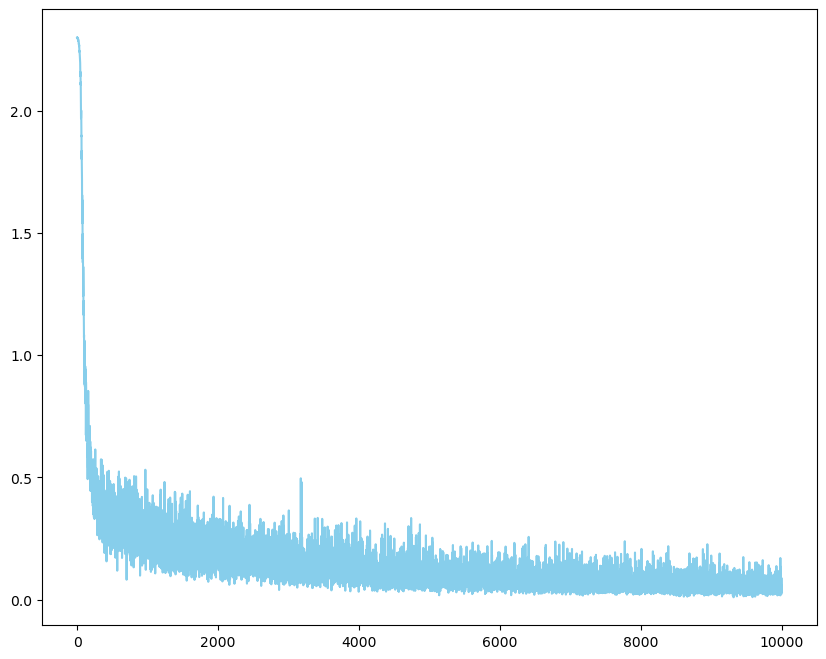

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
iteration = [i for i in range(iters_num)]
plt.plot(iteration, train_loss_list, color='skyblue')